In [2]:
import pickle
with open('addons/imr90/coop_matrix_all_new_spaced_3_new_orient.pkl', 'rb') as handle:
    values_fresh = pickle.load(handle)

In [3]:
import numpy as np
from scipy.stats import wilcoxon
from scipy.spatial import distance


# def profile_define_cooperative_net_pos_neg(motif1_only, motif2_only, cooop, controls):
    
#     effects = []
#     significance = []
#     max_coop = []
#     #print(len(cooop))
#     for i in range(len(cooop)):
#         n = controls[0]
#         #print((motif2_only[i][0]+motif1_only[i][0]).shape)
#         m2_m2 =  distance.jensenshannon(motif2_only[i][0]+motif1_only[i][0],n,axis=1)
#         m1_m2_coop = distance.jensenshannon(cooop[i][0],n,axis=1)
        
#         max_coop.append(m1_m2_coop)
        
        
#         Z = np.squeeze(m1_m2_coop - m2_m2)
        
#         res = wilcoxon(Z)
#         statistic = res.statistic
#         pvalue = res.pvalue
#         effects.append(np.mean(Z/m2_m2))
#         significance.append(pvalue)
        
    
#     #print(len(effects))
   
#     #idx = np.argmin(np.abs(significance))
#     idx = np.argmax(np.abs(effects))
#     nmin=np.max([np.log(motif1_only[idx][1]),np.log(motif2_only[idx][1])], axis=0)
#     nmax=np.log(motif1_only[idx][1])+np.log(motif2_only[idx][1])
#     zscore = np.mean((max_coop[idx]-nmin)/(nmax-nmin))
#     #print(idx)
#     return effects[idx], significance[idx]

def define_cooperative_net_pos_neg(motif1_only, motif2_only, cooop, controls, dists):
    
    effects = []
    significance = []
    max_coop = []
    stats = []
    zscores = []
    #print(len(cooop))
    for i in range(len(cooop)):
        n = np.log(controls[1])
        m1 = np.log(motif1_only[i][1])
        m2 = np.log(motif2_only[i][1])
        m1_m2 = np.log(cooop[i][1])
        max_coop.append(m1_m2)
        Y =  m1_m2-n
        
        
        
        Z = np.squeeze(Y - m1 - m2 + 2*n)
    
        
        
        res = wilcoxon(Z)
        statistic = res.statistic
        pvalue = res.pvalue
        effects.append(np.mean(Z))
        significance.append(pvalue)
        stats.append(statistic)
        
        nmax=np.log(motif1_only[i][1])+np.log(motif2_only[i][1])
        nmin=np.max([np.log(motif1_only[i][1]),np.log(motif2_only[i][1])], axis=0)
        zscore = np.mean((max_coop-nmin)/(nmax-nmin))

    
        zscores.append(zscore)
        
    
    #print(len(effects))
   
    if pvalue > 0.005:
        color = 0
    else:
        if np.mean(Z) > 0:
            color = 1
        else:
            z1 = Y-(m1-m2)
            if np.mean(z1) < 0:
                color=2
            else:
                color=3
                
    idx = np.argmin(np.abs(significance))
    print(dists[idx])
    #idx = np.argmax(np.abs(effects))
    #nmin=np.max([np.log(motif1_only[idx][1]),np.log(motif2_only[idx][1])], axis=0)

    #nmin=np.abs(np.log(motif1_only[idx][1]) - np.log(motif2_only[idx][1]))

    return  zscores[idx], significance[idx], color
    # return effects[idx], significance[idx]

In [4]:
import pandas as pd
annotations = pd.read_csv("addons/imr90/imr90.counts.tomtom.motifs_string.tsv",header=0, sep="\t")


In [5]:
annotations.shape


(30, 24)

In [6]:
import sklearn.cluster
import scipy.cluster.hierarchy
import scipy.stats

def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds

In [7]:
key="metacluster_0.pattern_0-metacluster_0.pattern_1"
effects=np.zeros((30,30))
coop_matrix_n=np.zeros((30,30))
sig_coop_matrix_n=np.zeros((30,30))

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors


row_names = []

for i in range(annotations.shape[0]):
    row_names.append(annotations.loc[i,"Label"])
    print(row_names[i])
    for j in range(i,annotations.shape[0]):
        label1 = annotations.loc[i,"Pattern"] + "-" + annotations.loc[j,"Pattern"]
        if i!=j:
            print(values_fresh[label1][1])
            controls = values_fresh["control"]
            [motif1_only, motif2_only, data_in_spacings, motif1_only_rev, motif2_only_rev, data_in_spacings_rev, distances] = values_fresh[label1][0]
        
            scores, significance, color = define_cooperative_net_pos_neg(motif1_only, motif2_only, data_in_spacings, controls, distances[0:len(data_in_spacings)])
            print(scores)
            effects[j,i] = scores
            coop_matrix_n[j,i] = color
            sig_coop_matrix_n[j,i] = significance    
        
            scores, significance, color = define_cooperative_net_pos_neg(motif1_only_rev, motif2_only_rev, data_in_spacings_rev, controls, distances[len(data_in_spacings):])
            
            effects[i,j] = scores
            coop_matrix_n[i,j] = color
            print(scores)
            sig_coop_matrix_n[i,j] = significance 
            
            #print(sig_coop_matrix_n[i,j])
            #print(sig_coop_matrix_n[j,i])
        else:
            print(values_fresh[label1][1])
            controls = values_fresh["control"]
            [motif1_only, motif2_only, data_in_spacings, motif1_only_rev, motif2_only_rev, data_in_spacings_rev, distances] = values_fresh[label1][0]
        
            scores, significance, color = define_cooperative_net_pos_neg(motif1_only, motif2_only, data_in_spacings, controls, distances[0:len(data_in_spacings)])
            
            effects[j,i] = scores
            coop_matrix_n[j,i] = color
            print(scores)
            sig_coop_matrix_n[j,i] = significance    
                 
#row_names.append(annotations.loc[annotations.shape[0]-1,"Label"])

            


FOS
FOS-FOS
140
0.1791041
FOS-CTCF
3
0.0014274933
-5
0.00065467454
FOS-FOXC1
9
0.16207592
-4
0.15184003
FOS-FOSB+JUNB
2
0.20503575
-3
0.18431987
FOS-SP1/KLF
140
0.10819452
-140
0.093183234
FOS-NFIC
4
0.1204025
-4
0.12577185
FOS-CEBPB
5
0.17418122
-120
0.13919502
FOS-NFYB
5
0.0032672558
-40
0.022819784
FOS-ELK
140
0.056242943
-8
0.07566395
FOS-LYL1
6
0.1384977
-40
0.151363
FOS-RUNX
7
0.1089921
-2
0.1651302
FOS-NRF1
140
0.07919898
-140
0.07119136
FOS-ETS1
40
0.15191136
-7
0.15251914
FOS-ATF4
3
0.19302918
-2
0.202575
FOS-ATF1
2
0.11967949
-120
0.099333785
FOS-TEAD4
3
0.22000086
-11
0.1592721
FOS-IRF1
120
0.10664272
-140
0.112762466
FOS-ZNF76
140
0.07831606
-8
0.015625028
FOS-SIX1
150
0.10512148
-150
0.10095269
FOS-TYY1
1
-0.028225653
-1
-0.023007795
FOS-ARNTL
130
0.12380841
-140
0.11724841
FOS-SRF
6
-0.014385246
-140
0.012216645
FOS-IRF4
3
0.111379266
-140
0.066470176
FOS-RFX2
140
0.101627715
-120
0.10013533
FOS-ZBTB33
140
0.06197904
-140
0.05790189
FOS-REST
130
0.0825303
-140
0.07881687


12
0.06968121
-8
0.061740752
NFYB-RFX2
9
0.047737177
-2
0.06871843
NFYB-ZBTB33
5
0.07413854
-5
0.11133818
NFYB-REST
20
0.016058818
-7
0.03442442
NFYB-ZNF76.1
14
0.12255744
-1
0.123725675
NFYB-ZEB1
4
-0.07077497
-15
-0.07530867
NFYB-JUNB
3
0.0165555
-6
0.00585027
NFYB-TBD
2
-0.004719144
-3
0.026767142
ELK
ELK-ELK
9
0.12947778
ELK-LYL1
9
0.06240648
-11
0.06993064
ELK-RUNX
6
0.027614031
-13
0.031334944
ELK-NRF1
20
0.16465452
-12
0.14712037
ELK-ETS1
6
0.09833872
-12
0.11977005
ELK-ATF4
1
0.071508825
-5
0.06616518
ELK-ATF1
11
0.08140106
-14
0.09129044
ELK-TEAD4
3
0.05150325
-5
0.064176366
ELK-IRF1
13
0.07000139
-60
0.09826988
ELK-ZNF76
15
0.110655986
-12
0.12070082
ELK-SIX1
3
0.08976266
-11
0.058887433
ELK-TYY1
7
0.12251892
-14
0.122212544
ELK-ARNTL
9
0.17902869
-2
0.1815403
ELK-SRF
15
0.029628107
-13
0.033781912
ELK-IRF4
12
0.120307505
-8
0.12166636
ELK-RFX2
9
0.11565418
-3
0.12315815
ELK-ZBTB33
6
0.17195414
-12
0.16925453
ELK-REST
140
0.06708591
-10
0.0631464
ELK-ZNF76.1
1
0.17482962
-7
0

3
-0.009775365
-150
0.003500045
SRF
SRF-SRF
1
-0.015295592
SRF-IRF4
4
0.029341755
-6
0.030997528
SRF-RFX2
3
0.032998733
-2
0.050899316
SRF-ZBTB33
3
0.03470962
-1
0.07732229
SRF-REST
5
0.010106713
-7
0.031147573
SRF-ZNF76.1
1
0.07513003
-4
0.058718495
SRF-ZEB1
7
-0.052060284
-12
-0.056434613
SRF-JUNB
3
0.021222664
-50
-0.0069008805
SRF-TBD
1
0.004726055
-2
0.009048598
IRF4
IRF4-IRF4
11
0.1040857
IRF4-RFX2
6
0.118374735
-14
0.10145319
IRF4-ZBTB33
5
0.17980526
-3
0.17849979
IRF4-REST
20
0.078120664
-13
0.074995644
IRF4-ZNF76.1
1
0.18691349
-7
0.168878
IRF4-ZEB1
2
-0.06165369
-4
-0.070066884
IRF4-JUNB
3
0.033669375
-1
0.04216421
IRF4-TBD
1
0.016890788
-150
0.010186361
RFX2
RFX2-RFX2
120
0.11261393
RFX2-ZBTB33
6
0.17544474
-2
0.17827486
RFX2-REST
120
0.094714865
-7
0.091972165
RFX2-ZNF76.1
2
0.17624773
-2
0.17365995
RFX2-ZEB1
3
-0.11013634
-15
-0.11011196
RFX2-JUNB
20
0.038789157
-1
0.047121726
RFX2-TBD
3
-0.0014875133
-2
0.040548746
ZBTB33
ZBTB33-ZBTB33
7
0.23386453
ZBTB33-REST
10
0.109137

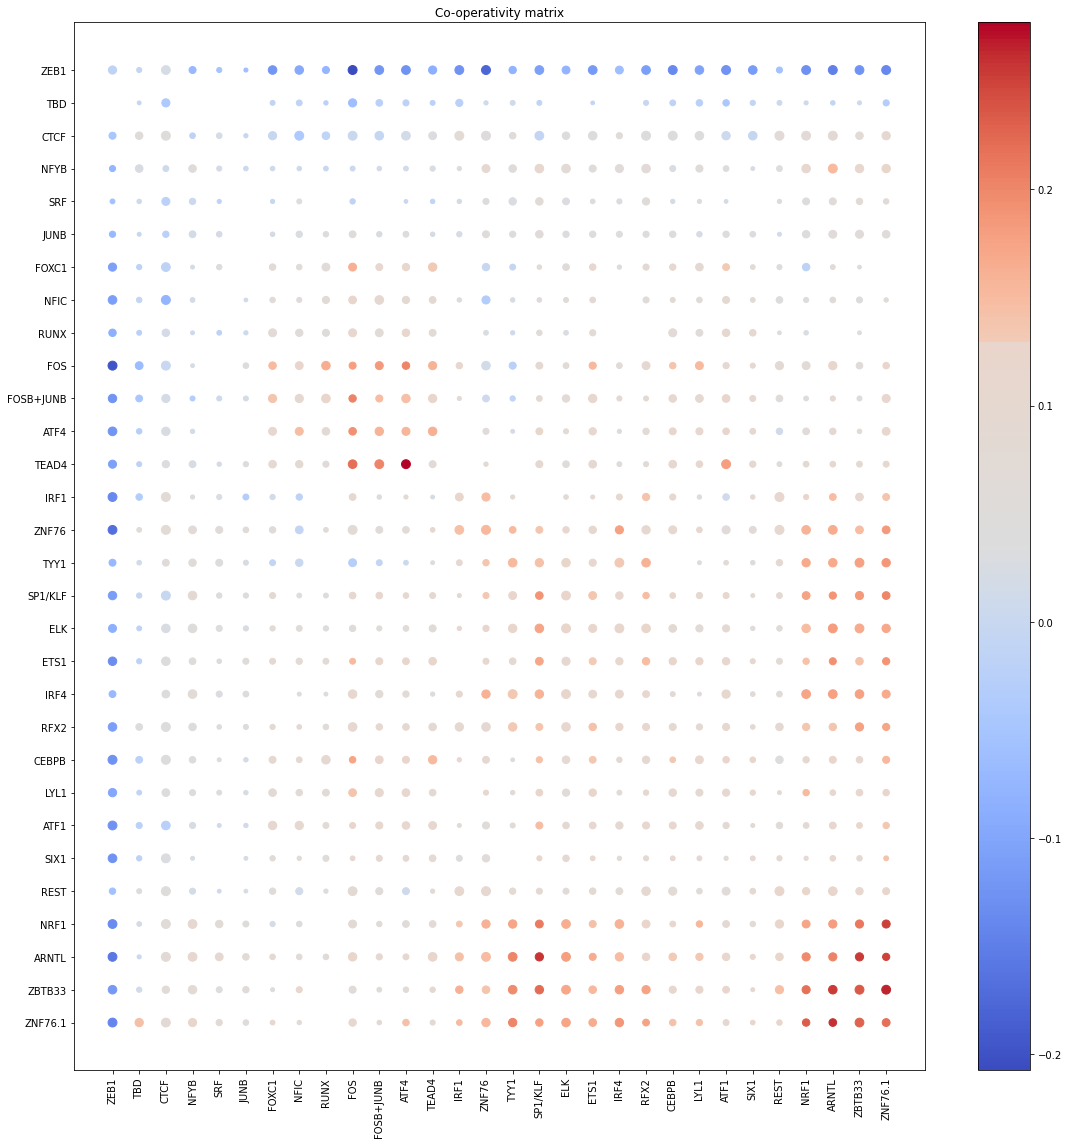

In [8]:
# define the colormap
#cmap = plt.get_cmap('PuOr')
# extract all colors from the .jet map
#cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)


import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import BoundaryNorm
from matplotlib import colors
# Create a figure with the right dimensions
fig, ax = plt.subplots(figsize=(16, 16))


norm = TwoSlopeNorm(vmin=effects.min(), vcenter=(effects.min()+effects.max())/2, vmax=effects.max())
#inds = cluster_matrix_indices(coop_matrix_n,10)
inds = cluster_matrix_indices(effects,10)

colors_undersea = plt.cm.coolwarm(np.linspace(0, 0.5, 256))
colors_land = plt.cm.coolwarm(np.append(np.linspace(0.5, 0.55, 100),np.linspace(0.6, 1, 256-100)))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = colors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)

# generate coordinates for the image. Note that the image is "top down", so the y coordinate goes from high to low.
ys, xs = np.mgrid[coop_matrix_n.shape[1]:0:-1,0:coop_matrix_n.shape[1]]

# Scatter plots take 1d arrays of xs and ys, and the colour takes a 2d array,
# with the second dimension being RGB
sizes=np.log(sig_coop_matrix_n[inds][:,inds]+1e-20)*-2
sizes[sizes<(np.log(0.001+1e-20)*-2)]=0
hmap = ax.scatter(xs.flatten(), ys.flatten(), s=sizes,
             c=effects[inds][:,inds], cmap=terrain_map, norm=norm, edgecolor='face')
colors1 = ["#D3D3D3", "red", "blue", "green"]
cmap = colors.ListedColormap(colors1)


int_to_str_mapping= {0:"#D3D3D3", 1:"red", 2:"blue", 3:"green"}
str_2d_array = np.vectorize(int_to_str_mapping.get)(coop_matrix_n)
#hmap = ax.scatter(xs.flatten(), ys.flatten(), s=np.log(sig_coop_matrix_n[inds][:,inds]+1e-20)*-1,
#            c=effects, edgecolor='face')


#np.log(sig_coop_matrix_n[inds][:,inds]+1e-20)*-20
#np.abs(coop_matrix_n[inds][:,inds])*500
# plotting
#hmap = plt.imshow(ls.blend_hsv(z_data_rgb, coop_matrix[inds][:, inds]))


# Set axes on heatmap
ax.set_yticks(np.arange(1,len(row_names)+1))
ax.set_yticklabels(np.array(row_names)[inds][::-1])
ax.set_xticks(np.arange(len(row_names)))
ax.set_xticklabels(np.array(row_names)[inds], rotation=90)

#Loop over data dimensions and create text annotations.
#for i in range(len(row_names)):
#    for j in range(len(row_names)):
#        if np.round(coop_matrix_n[inds][i, j],2) !=0 :
#            ax.text(j, i, np.round(coop_matrix_n[inds][i, j],2), ha="center", va="center")
fig.colorbar(hmap, orientation="vertical")

ax.set_title("Co-operativity matrix")
fig.tight_layout()
    
#plt.savefig("subfigs/motif_cooperativiity_imr90_dotplot.pdf", dpi=300, transparent=True)

plt.show()

In [9]:
np.log(0.005+1e-20)

-5.298317366548036

In [10]:
np.min(sig_coop_matrix_n)

3.896559845095909e-18

In [11]:
np.array(zscores).shape

distance = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40,-50,-60,-70,-80,-90,-100,-110,-120,-130,-140,-150]

distance = distance[::-1]+[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,60,70,80,90,100,110,120,130,140,150]

NameError: name 'zscores' is not defined

In [12]:
len(distance)

TypeError: object of type 'module' has no len()

In [13]:
for key in zscores:
    print(np.array(zscores[key]).shape)

NameError: name 'zscores' is not defined

In [14]:
for key in zscores:
    fig, ax = plt.subplots(figsize=(50, 20))
    inds = cluster_matrix_indices(np.array(zscores[key])[:,:,0],10)
    print(key)
    hmap = ax.imshow(np.array(zscores[key])[inds,:,0], cmap=terrain_map, norm=norm)
    cbar = fig.colorbar(hmap, orientation="vertical")
    ax.set_xticks(np.arange(56))
    ax.set_xticklabels(distance, rotation=90, fontsize=25)
    ax.set_yticks(np.arange(len(rlables[key])))
    ax.set_yticklabels(np.array(rlables[key])[inds], fontsize=25)
    plt.show()
    
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(25)

NameError: name 'zscores' is not defined

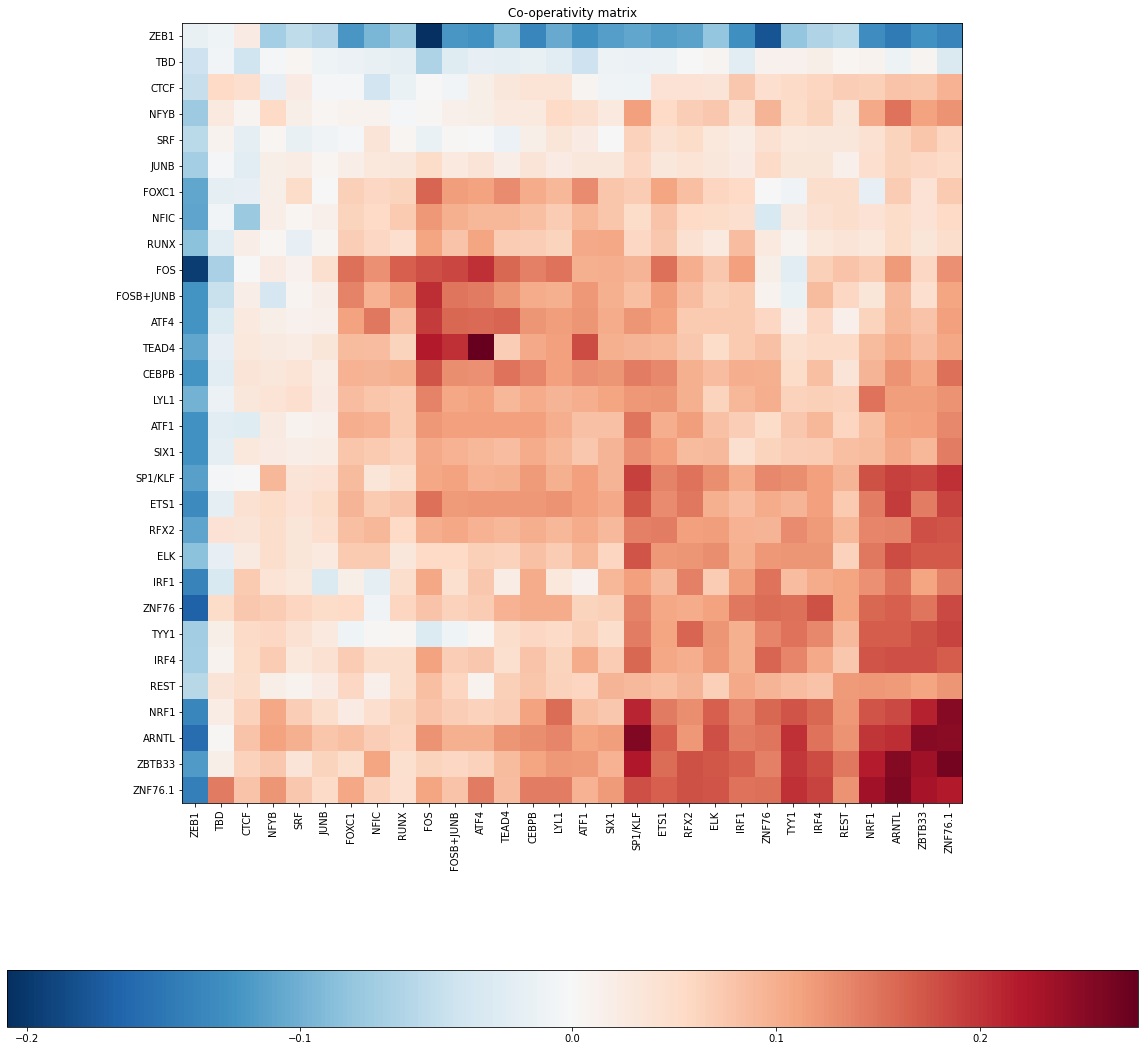

In [15]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Create a figure with the right dimensions
fig, ax = plt.subplots(figsize=(16, 16))

# define the colormap
#cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
#cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)


norm = TwoSlopeNorm(vmin=effects.min(), vcenter=0, vmax=effects.max())

inds = cluster_matrix_indices(effects,10)

# Plot the heatmap
# defining light source
#ls = mcolors.LightSource()

hmap = ax.imshow(effects[inds][:,inds], norm=norm, cmap="RdBu_r")
#hmap = ax.imshow(coop_matrix)


# plotting
#hmap = plt.imshow(ls.blend_hsv(z_data_rgb, coop_matrix[inds][:, inds]))


# Set axes on heatmap
ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(np.array(row_names)[inds])
ax.set_xticks(np.arange(len(row_names)))
ax.set_xticklabels(np.array(row_names)[inds], rotation=90)

#Loop over data dimensions and create text annotations.
#for i in range(len(row_names)):
#    for j in range(len(row_names)):
#        if np.round(coop_matrix_n[inds][i, j],2) !=0 :
#            ax.text(j, i, np.round(coop_matrix_n[inds][i, j],2), ha="center", va="center")
fig.colorbar(hmap, orientation="horizontal")

ax.set_title("Co-operativity matrix")
fig.tight_layout()

#plt.savefig("subfigs/motif_cooperativiity_imr90_2.pdf", dpi=300, transparent=True)


In [87]:
print(coop_matrix_n.max())

1.0178497509763884


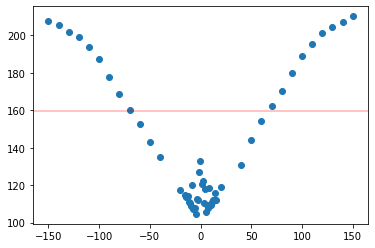

In [81]:
keyd="metacluster_0.pattern_0-metacluster_1.pattern_0"
plt.scatter(values2[keyd][0][3],values2[keyd][0][2])
#plt.axhline(values2[keyd][0]+values2[keyd][1], color="blue", alpha=0.3)
#plt.axhline(values2[keyd][0][0][0], color="green", alpha=0.3)
plt.axhline(np.abs(values2[keyd][0][0][0]-values2[keyd][0][1][0]), color="red", alpha=0.3)
plt.savefig("subfigs/zeb_fos_coord_effect_syntax.pdf", transparent=True, dpi=300)


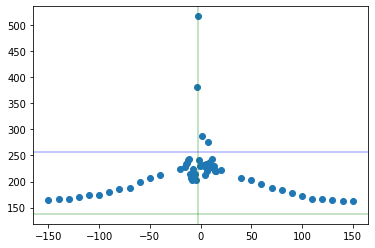

In [79]:
keyd="metacluster_0.pattern_4-metacluster_0.pattern_19"
plt.scatter(values2[keyd][0][3],values2[keyd][0][2])
plt.axhline(values2[keyd][0][0][0]+values2[keyd][0][1][0], color="blue", alpha=0.3)
plt.axhline(values2[keyd][0][0][0], color="green", alpha=0.3)
plt.axvline(-3, color="green", alpha=0.3)

#plt.axhline(np.abs(values2[keyd][0][0][0]-values2[keyd][0][1][0]), color="red", alpha=0.3)


In [77]:
#values2.keys()